In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
from statannotations.Annotator import Annotator

In [2]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [3]:
origin = load_data('styptic')
origin

[data] https://data.hossam.kr/data/lab10_/styptic.xlsx
[desc] 실험 참가자를 두 그룹으로 임의 분할한 후 피부에 작은 상처를 내어 피가 흐르게 한 다음, 한 그룹에는 지혈제 B를 다른 그룹에는 지혈제 G를 투여하여 완전히 지혈될 때 까지의 시간(분)을 측정한 두 종료의 지혈제 효과를 측정한 자료 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata


,B,G
0,8.80,9.9
1,8.90,10.0
2,8.40,9.0
3,7.90,11.1
4,8.20,9.8
5,8.70,9.6
6,7.90,10.3
7,9.10,8.7
8,9.60,10.4
9,8.75,9.5


# 신뢰구간 확인

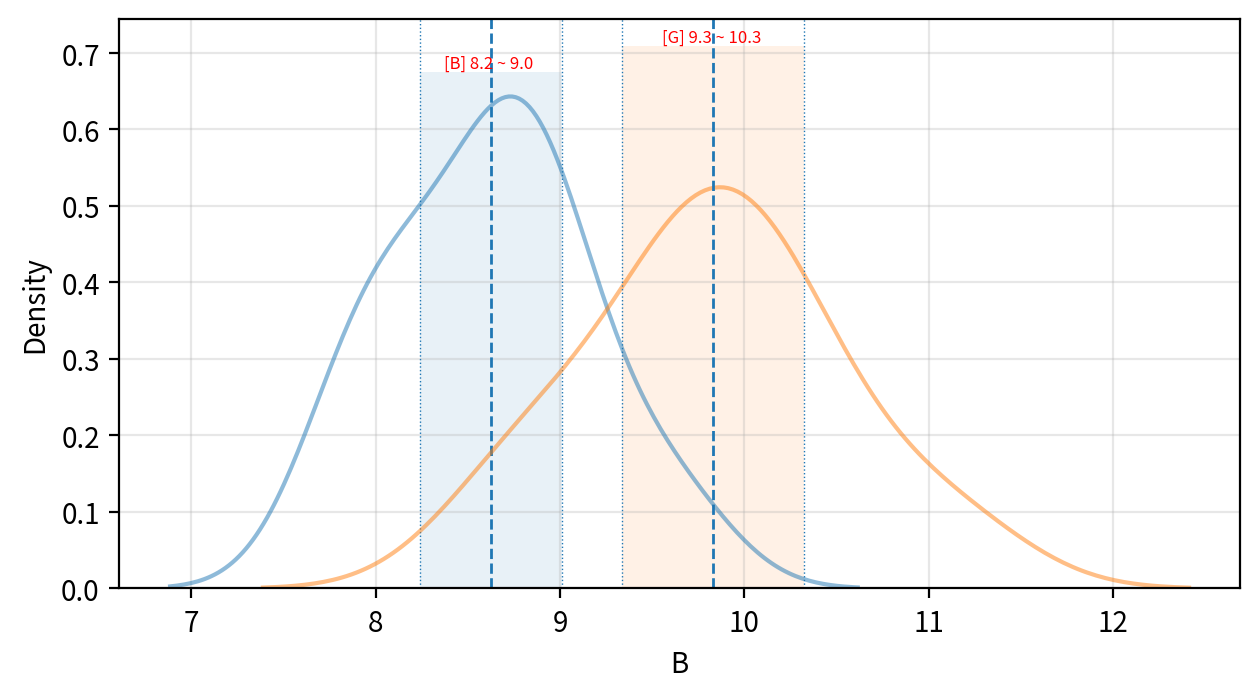

In [4]:
data = origin[['B','G']] #확인할 데이터

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)



for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    max = data[c].max()
    clevel = 0.95
    dof = len(data[c])-1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ax.text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (c, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})

ax.grid(True, alpha=0.3)






plt.tight_layout()
plt.show()
plt.close()

두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다. 또한 두 그룹 모두 표본 평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다.

In [5]:
data = origin[['B','G']]

equal_var_fields=[]
normal_dist = True
report = []

for c in data.columns:
    s, p =normaltest(data[c])

    normalize = p>0.05
    report.append({
        "field":c,
        "statistic":s,
        "p-value" : p,
        "result":normalize
    })
    normal_dist = normal_dist and normalize
#변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns)>1:
    if normal_dist:
        n = "Bartlett"
        #정규성을 충족할 경우의 검정방법
        s,p = bartlett(*data.values.T)
        #모든 컬럼의 데이터를 한번에 전달

    else:
        n = "Levene"    #정규성을 충족하지 않을 경우의 검정방법

        s, p = levene(*data.values.T, center='median')  # 모든 컬럼의 데이터를 한번에 전달

    report.append({
        "field":n,
        "statistic":s,
        "p-value" : p,
        "result":p>0.05
    })

report_df = DataFrame(report).set_index('field')
report_df






,statistic,p-value,result
field,,,
B,0.083269,0.959221,True
G,0.200950,0.904408,True
Bartlett,0.555515,0.456073,True


정규성과 등분산성을 충족함.

In [6]:
s, p =ttest_ind(origin['B'], origin['G'])

"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -4.350, p-value: 0.000, 대립가설 채택'

 p-value가 0.05보다 작으므로(p ≤ 0.05) 지혈제 B를 사용한 그룹과 지혈제 G를 사용한
그룹간 평균 지혈시간에는 차이가 있다.

In [7]:
s, p =ttest_ind(origin['B'], origin['G'], alternative='greater')

"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -4.350, p-value: 1.000, 귀무가설 채택'

 p-value가 
0.05보다 크므로(P > 0.05) 지혈제 B를 사용한 그룹의 평균 지혈 시간은 지혈
제 G를 사용한 그룹의 평균 지혈시간보다 크지 않다는 귀무가설을 기각할 수 없다.

In [8]:
s, p = ttest_ind(origin['B'], origin['G'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -4.350, p-value: 0.000, 대립가설 채택'

 p-value가 0.05보다 작으므로(P ≤ 0.05) 귀무가설을 기각하고 대립가설을 채택한다.
즉, 지혈제 B를 사용한 그룹의 평균 지혈 시간은 지혈제 G를 사용한 그룹의 평균 지혈시간
작다.

In [9]:
df = melt(origin, var_name = 'group', value_name='value')
df

,group,value
0,B,8.80
1,B,8.90
2,B,8.40
3,B,7.90
4,B,8.20
5,B,8.70
6,B,7.90
7,B,9.10
8,B,9.60
9,B,8.75


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

B vs. G: t-test independent samples, P_val:3.862e-04 t=-4.350e+00


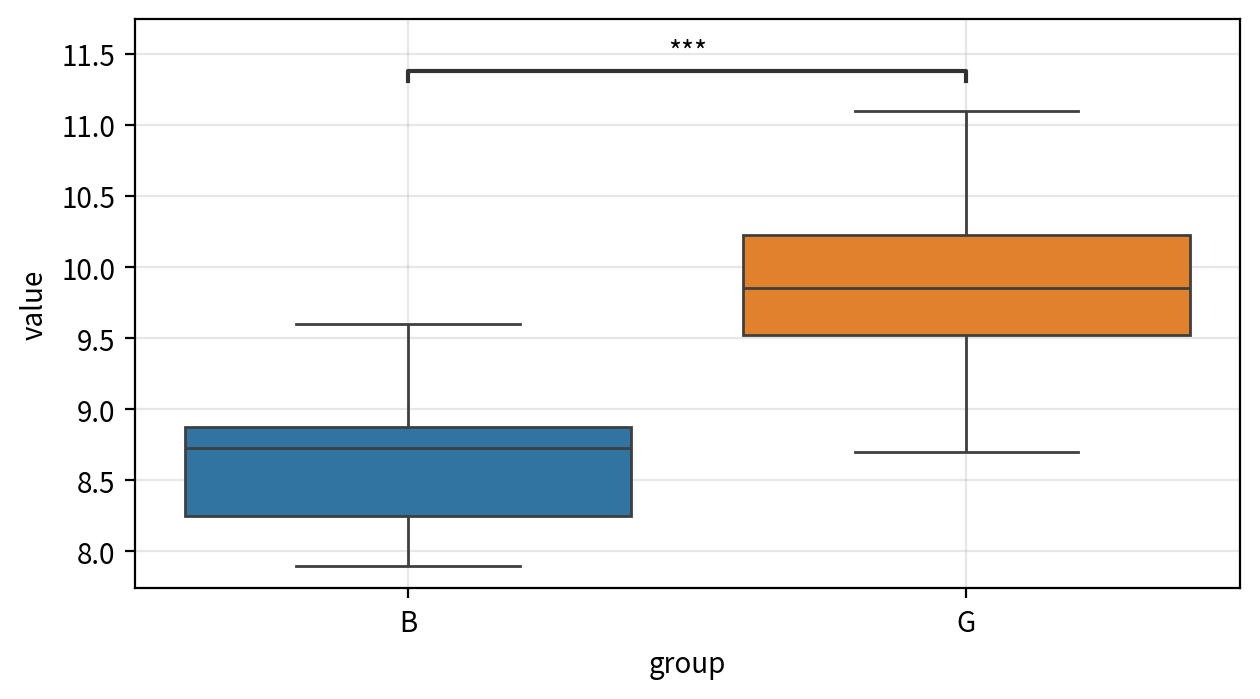

In [10]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.boxplot(data=df, x='group', y='value', hue='group')

annotator = Annotator(ax, data=df, x='group', y='value', pairs=[('B','G')])
annotator.configure(test='t-test_ind')
annotator.apply_and_annotate()

ax.grid(True,alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()

# 인공심장 효과 측정 예제

In [11]:
origin = load_data("heatrate")
origin

[data] https://data.hossam.kr/data/lab10_/heatrate.xlsx
[desc] 두 독립적인 그룹의 심장병 환자에 대한 심장계수(cardiac index)를 측정한 데이터. `그룹1`은 심장수술을 받고 부착한 인공장기의 기능이 정상적인 사람들이고, `그룹2`는 비정상으로 판명된 사람들이다.심장계수는 수술 직후에 측정하였다. (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata


,그룹1,그룹2
0,3.84,3.97
1,2.60,2.50
2,1.19,2.70
3,2.00,3.36
4,6.20,3.55
5,0.96,2.97
6,5.50,3.20
7,3.18,2.30


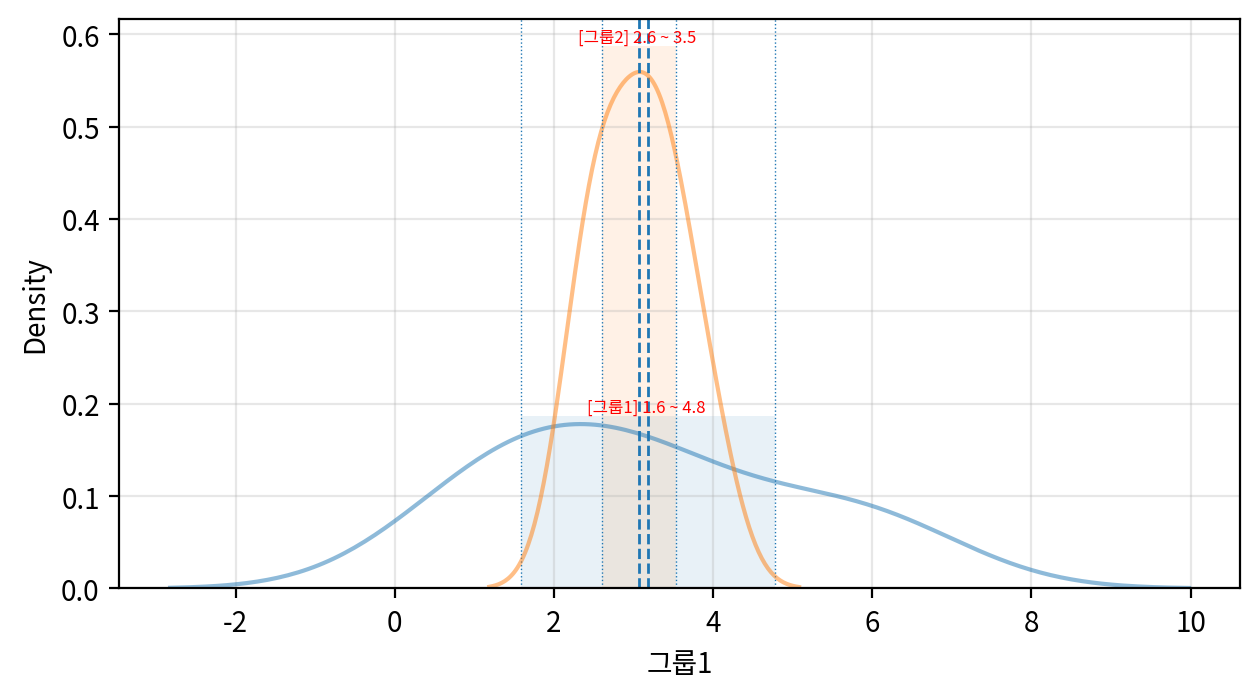

In [12]:
data = origin[['그룹1','그룹2']]    #확인할 데이터

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    max = data[c].max()
    clevel = 0.95
    dof = len(data[c])-1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ax.text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (c, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})

ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()

두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.

또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다.

In [13]:
data = origin[['그룹1','그룹2']]

equal_var_fields=[]
normal_dist = True
report = []

for c in data.columns:
    s, p =normaltest(data[c])

    normalize = p>0.05
    report.append({
        "field":c,
        "statistic":s,
        "p-value" : p,
        "result":normalize
    })
    normal_dist = normal_dist and normalize
#변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns)>1:
    if normal_dist:
        n = "Bartlett"
        #정규성을 충족할 경우의 검정방법
        s,p = bartlett(*data.values.T)
        #모든 컬럼의 데이터를 한번에 전달

    else:
        n = "Levene"    #정규성을 충족하지 않을 경우의 검정방법

        s, p = levene(*data.values.T, center='median')  # 모든 컬럼의 데이터를 한번에 전달

    report.append({
        "field":n,
        "statistic":s,
        "p-value" : p,
        "result":p>0.05
    })

report_df = DataFrame(report).set_index('field')
report_df






,statistic,p-value,result
field,,,
그룹1,0.839625,0.657170,True
그룹2,0.260764,0.877760,True
Bartlett,8.029088,0.004603,False


정규성은 만족하지만 등분산성을 만족하지는 않는다. 

In [14]:
s, p =ttest_ind(origin['그룹1'], origin['그룹2'], alternative='two-sided', equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 0.163, p-value: 0.874, 귀무가설 채택'

p-value가 0.05보다 크므로(p>0.05)귀무가설을 기각할 수 없다. 즉, 두 그룹의 심장계수가 다르다고 판단할 근거가 없다.

In [15]:
s, t = ttest_ind(origin['그룹1'], origin['그룹2'], alternative='less', 
equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 0.163, p-value: 0.874, 귀무가설 채택'

p-value가 0.05보다 크므로 (P>0.05)귀무가설을 기가할 수 없다.
즉, 그룹1의 심장계수는 그룹2의 심장계수보다 작지 않다.

In [16]:
s, t = ttest_ind(origin['그룹1'], origin['그룹2'], alternative='greater', equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 0.163, p-value: 0.874, 귀무가설 채택'

p-value가 0.05보다 크므로(P>0.05)귀무가설을 기각할 수 없다.
즉, 그룹1의 심장계수가 그룹2의 심장계수보다 크지 않다.

In [17]:
df = melt(origin, var_name='group', value_name='value')
df

,group,value
0,그룹1,3.84
1,그룹1,2.60
2,그룹1,1.19
3,그룹1,2.00
4,그룹1,6.20
5,그룹1,0.96
6,그룹1,5.50
7,그룹1,3.18
8,그룹2,3.97
9,그룹2,2.50


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹1 vs. 그룹2: Welch's t-test independent samples, P_val:8.742e-01 t=1.633e-01


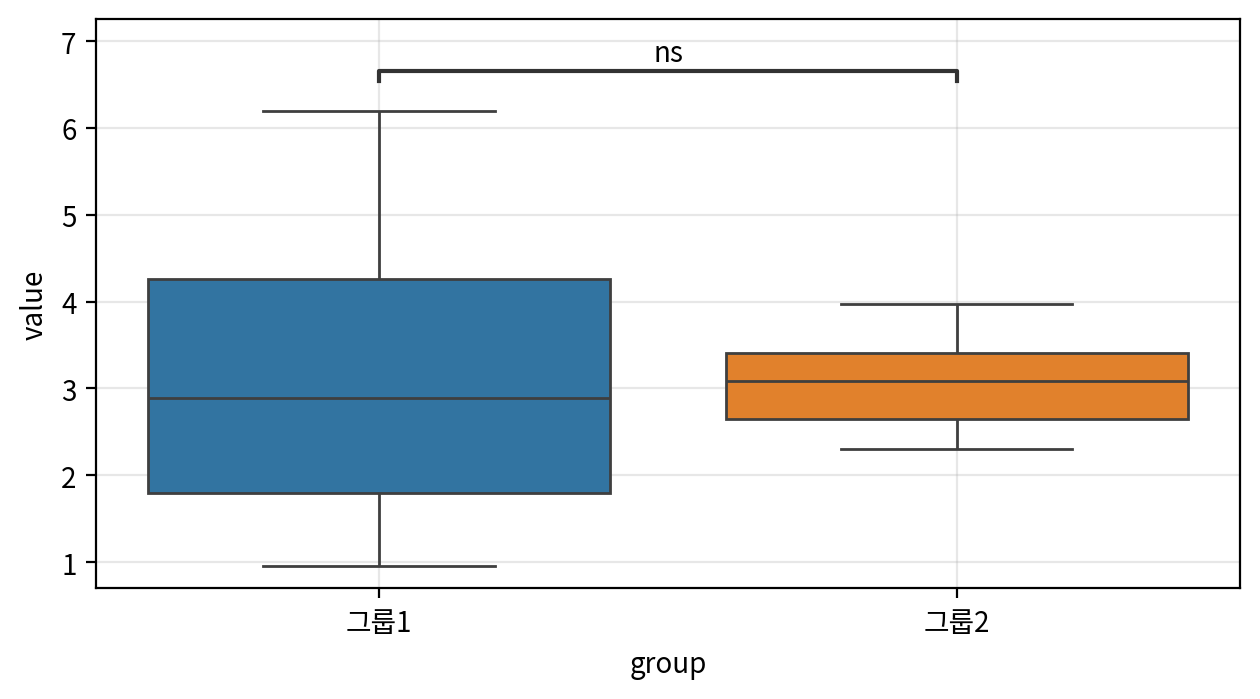

In [18]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.boxplot(data=df, x='group',y='value',hue='group')
annotator = Annotator(ax, data=df, x='group', y='value', pairs=[("그룹1", "그룹2")])
annotator.configure(test='t-test_welch')
annotator.apply_and_annotate()

ax.grid(True,alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()